# Cerebellar Model Articulation Controller(CMAC)


## 概论
小脑模型的初始设想很简单，希望设计一个这样的模型：

1. **足够快**
2. **拟合**

### 足够快
对于第一点，传统的神经网络均是使用浮点数进行计算，使用浮点数显然存在两个缺点：其一是占用空间大，其二是运算不够快。但也存在非常明显的优点：计算精度高。

若为了在不太降低精度的条件下尽可能提高模型运算效率，显然有两个角度：其一是改进模型，其二是改变数值存储方式。

量化技术就是这样一类通过改变数值存储方式提高模型运算效率的方式。对于现代神经网络，训练通常采用32位浮点数，推理时则可以选用16位浮点数以提高精度，而当部署到边缘设备上时则可以进一步采用**int8量化技术**。

对于CMAC，同样的，为了提升运算效率，初始数据输入时会进行量化。此外，为了进一步提升效率，CMAC还引入了**哈希散列**，通过查表的方式将相近的输入映射到相似的地址上。

哈希散列同时也引入了不确定的因素。哈希散列是一种压缩映射，其很有可能将不同的输入映射到同一个地址，即导致了**碰撞**。从另一个角度讲，这也引入了非线性变换，即在原空间可能相隔非常远的两个输入，在映射后可能十分相近甚至发生**碰撞**。


### 拟合
为了实现拟合，CMAC在查表后建立了一个自适应线性层，实现地址到输出的线性估计
由于采用了哈希，实际上建立了输入与地址的映射表。在不考虑碰撞的情况下，一个特定的输入会激活特定的地址，而特定的地址会激活特定的自适应线性层的输入单元，这些单元则会连接到输出。

不同于传统的神经网络，进行推理时同层所有的神经元均会参与运算，CMAC中仅有被激活的输入单元才会参与运算，这显然也加速了CMAC的运算速度。


## 符号定义

### 空间
|符号|含义|
|:-:|:-:|
|$S$|输入空间|
|$M$|扩充地址空间|
|$MC$|扩充地址空间长度|
|$A_c$|虚拟存储空间|
|$A_p$|实际存储空间|
|$F$|输出空间|

### 数据
|符号|含义|
|:-:|:-:|
|$\bm{s}$|输入向量|
|$\bm{m}$|扩充后矩阵|
|$\bm{a}$|虚拟存储空间向量|
|$\bm{d}$|实际存储空间向量|
|$\hat{y}$|预测输出|
|$y$|真实输出|

### 参数
|符号|含义|
|:-:|:-:|
|s|输入空间维度|
|q|量化级|
|c|扩充地址维度|
|$N_p$|用于Hash运算的质数|
|$\bm{W}$|权矩阵|

## 正向运算

CMAC的整体流程如下：

* 输入空间$S$离散化
* 输入空间$S$ $\rightarrow$ 扩充地址空间$M$
* 扩充地址空间$M$ $\rightarrow$ 虚拟存储空间$A_c$
* 虚拟存储空间$A_c$ $\rightarrow$ 实际存储空间$A_p$
* 实际存储空间$A_p$ $\rightarrow$ 输出空间$F$

第零步为离散化。一方面是加速运算，另一方面也是配合后续的Hash

第一步是在进行升维

第二步是将第一步中升维到高维的多个分量组合为一个向量

第三步为Hash

第四步为自适应线性拟合

### 离散化

输入为$\bm{s}=[s_1, s_2, \cdots, s_s]$

设定第n个维度的取值范围为$[n_{min}, n_{max}]$，量化级为q_n

则第n个维度的离散值为
$$
\begin{equation}
    s_n = \lceil\frac{(s_n-n_{min})}{(n_{max}-n_{min})}*q_n\rceil
\end{equation}
$$

### 输入空间到扩充地址空间

每一个输入分量均扩充到c维

对于一个特定的输入分量$s_n$，有对应的扩充后向量$\bm{m_n}$

扩充后向量按照如下的方式进行运算

定义如下的取余运算
$$
\begin{equation}
    \Psi(s_n) = mod(\frac{s_n-1}{c})+1
\end{equation}
$$
则$\bm{m_n}$的第$\Psi(s_n)$位为$s_n$，其他位依次推出

|$\bm{m_{n1}}$|$\bm{m_{n2}}$|$\cdots$|$\bm{m_{n\Psi(s_n)}}$|$\cdots$|$\bm{m_{nc}}$|
|:-:|:-:|:-:|:-:|:-:|:-:|
|$s_n+(c-\Psi(s_n)+1)$|$s_n+(c-\Psi(s_n)+2)$|$\cdots$|$s_n$|$\cdots$|$s_n+(c-\Psi(s_n))$|

### 扩充地址空间到虚拟存储空间

扩充地址空间为一个$s\times c$的矩阵，转换到虚拟存储空间后进行纵向连接，即进行如下操作

$$
\begin{equation}
    \bm{m} = 
    \left[\begin{array}{cc}
        m_{11}&m_{12}&\cdots&m_{1c} \\
        \vdots&\ddots&\ddots&\vdots \\
        m_{s1}&m_{s2}&\cdots&m_{sc}
    \end{array}\right]
\end{equation}
$$

$$
\begin{equation}
    \begin{split}
        \bm{a} 
        &= [a_1, a_2, \cdots, a_c]^T \\
        &= [m_{11}m_{21}\cdots m_{s1}, m_{12}m_{22}\cdots m_{s2}, \cdots, m_{1c}m_{2c}\cdots m_{sc}]^T 
    \end{split}
\end{equation}
$$

### 虚拟存储空间到实际存储空间

这一步即为Hash，在这里采用取余运算的方式，类似于式2有：

$$
\begin{equation}
    \Psi(a_n) = mod(\frac{a_n-1}{N_p})+1
\end{equation}
$$

$$
\begin{equation}
    \begin{split}
        \bm{d} 
        &= [d_1, d_2, \cdots, d_c]^T \\
        &= [\Psi(a_1), \Psi(a_2), \cdots, \Psi(a_c)]^T
    \end{split}
\end{equation}
$$


### 实际存储空间到输出空间

这一步采用简单的线性变换

上述得到的是地址，在CMAC中，为了加速运算，最终一步是通过查询实现的，

权矩阵$\bm{W}\in\mathcal{R}^{c \times N_p}$

其中$c$为地址的维度，$N_p$为取余运算的除数，对于以$N_p$为底的除法，显然得到的余数不可能大于$N_p$

输出即为对应地址位置的权值之和

$$
\begin{equation}
    \hat{y} = \sum_{i=0}^{c}W[i, \Psi(a_i)]
\end{equation}
$$

## 参数学习

定义损失函数

$$
\begin{equation}
    \mathcal{L} = ||\hat{y}-y||_2^2
\end{equation}
$$

对权值求偏导

$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{W}} 
    &= \frac{||\hat{y}-y||_2^2}{\partial \bm{W}} \\
    &= \frac{(\sum_{i=0}^{c}W[i, \Psi(a_i)]-y)^2}{\partial \bm{W}} \\
    &= 2(\sum_{i=0}^{c}W[i, \Psi(a_i)]-y)\frac{\sum_{i=0}^{c}W[i, \Psi(a_i)]}{\partial \bm{W}}
    \end{split}
\end{equation}
$$

$$
\begin{equation}
    \frac{\partial \mathcal{L}}{W_{ij}} = 
    \left\{
    \begin{array}{cc}
    0,&d_i \neq j+1 \\
    2(\sum_{i=0}^{c}W[i, \Psi(a_i)]-y),&else
    \end{array}
    \right. 
\end{equation}
$$

获得参数更新函数

$$
\begin{equation}
    \bm{W}(t+1) = \bm{W}(t) - \eta\frac{\partial \mathcal{L}}{\bm{W}(t)}
\end{equation}
$$

In [110]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import seaborn as sn

%matplotlib inline

In [3]:
class CMAC(object):

    def __init__(self, 
                 input_dim, 
                 input_range,  
                 q_level, 
                 expend_dim, 
                 hash_number,
                 lr):
        """
        input_dim: 输入维度
        input_range: 输入取值范围，默认需要一个list
        q_level: 量化级，默认需要输入一个list
        expend_dim: 扩充地址维度
        hash_number: 用于散列的质数
        lr: 学习率
        """

        self.input_dim = input_dim
        self.input_range = np.array(input_range)
        self.q_level = q_level
        self.expend_dim = expend_dim
        self.hash_number = hash_number
        self.lr = lr

        # 输出权值矩阵
        random.seed(1024)
        np.random.seed(1024)
        self.weight_matrix = np.random.rand(self.expend_dim, self.hash_number)

        # 数据存储空间向量
        self.real_vector = None
        self.output_vector = None
        
    
    def forward(self, x):
        """
        x: 输入向量
        """

        # ------------- 离散化 ---------------
        input_q = self._quantification(np.array(x))
        
        # ------------- 输入空间到扩充地址空间 ------------------
        # (self.expend_dim, self.input_dim)
        expend_matrix = self._input2expend(input_q)

        # ------------- 扩充地址空间到虚拟存储空间 -----------------
        # (self.expend_dim, 1)
        virtual_vector = self._expend2virtual(expend_matrix)

        # ------------- 虚拟存储空间到实际存储空间 ------------------
        # (self.expend_dim, 1)
        self.real_vector = self._virtual2real(virtual_vector)

        # ------------- 实际存储空间到输出空间 --------------------
        # (self.output_dim, 1)
        self.output_value = self._real2output(self.real_vector)

        return self.output_value
    
    def optim(self, true_output):
        """
        true_output: 真实输出
        """

        # 更新mask
        partial_matrix = np.zeros((self.expend_dim, self.hash_number))
        partial_matrix[range(0, self.expend_dim), self.real_vector.reshape(-1)-1] = 1
        self.weight_matrix -= self.lr * (self.output_value - true_output) * partial_matrix

    def _quantification(self, input_vector):
        """
        input_vector: 输入向量
        """
        if isinstance(self.q_level, int):
            self.q_level = np.ones((self.input_dim)) * self.q_level

        input_q = np.zeros(self.input_dim, dtype=np.int32)
        # (self.input_dim)
        for i in range(self.input_dim):
            _input_range = self.input_range[i, :]
            input_q[i] = np.math.ceil((input_vector[i]-_input_range[0])*self.q_level[i]/(_input_range[1]-_input_range[0]))

        return input_q

    def _input2expend(self, input_q):
        """
        input_q: 量化后的输入向量
        """
        expend_matrix = np.zeros((self.input_dim, self.expend_dim))

        for i in range(self.input_dim):
            
            # 计算取余运算
            phi_ = self.my_mod(input_q[i], self.expend_dim)
            
            if phi_ != 0:
                # index < phi_
                add_number_list_1 = np.array(range(0, phi_))+1
                # index > phi_
                add_number_list_2 = np.array(range(0, self.expend_dim-phi_))

                expend_matrix[i, :phi_] = input_q[i] + self.expend_dim - phi_ + add_number_list_1
                expend_matrix[i, phi_:] = input_q[i] + add_number_list_2
            else:
                expend_matrix[i] = input_q[i] + np.array(range(0, self.expend_dim))

        return expend_matrix.astype(np.int32).T
    
    @staticmethod
    def my_mod(input_, divisor):
        return (input_-1)%divisor + 1

    def _expend2virtual(self, expend_matrix):
        """
        expend_matrix: 扩充地址空间矩阵
        """
        virtual_vector = np.zeros((self.expend_dim, 1), dtype=np.int32)

        # 进行组合
        basic_multiplier = pow(10, len(str(self.expend_dim)))
        for i in range(self.input_dim):
            mul_num = pow(basic_multiplier, self.input_dim-1-i)
            virtual_vector += expend_matrix[:, i:i+1] * mul_num
    
        return virtual_vector
    
    def _virtual2real(self, virtual_vector):
        """
        virtual_vector: 虚拟存储空间向量
        """
        real_vector = np.zeros((self.expend_dim, 1), dtype=np.int32)
        for i in range(self.expend_dim):
            real_vector[i] = self.my_mod(virtual_vector[i], self.hash_number)

        return real_vector

    def _real2output(self, real_vector):
        """
        real_vector: 实际存储空间向量
        """
        output_value = np.sum(self.weight_matrix[range(0, self.expend_dim), real_vector.reshape(-1)-1])

        return output_value
        

In [4]:
# 测试数据

# 输入维度
input_dim = 2
# 输入范围
input_range = [[0, 1], [0, 0.8]]
# 量化级
q_levle = [5, 4]
# 扩充地址空间维度
expend_dim = 4
# 散列质数
hash_number = 19
# 学习率
lr = 0.1
# 输出维度
output_dim = 1

# 测试输入
input_vector = [0.8, 0]
# 测试输出
output_ = 1

my_cmac = CMAC(input_dim=input_dim,
               input_range=input_range,
               q_level=q_levle,
               expend_dim=expend_dim,
               hash_number=hash_number,
               lr=lr)

# 离散值输出
input_q = my_cmac._quantification(input_vector)
print("离散\n", input_q)
# 输入空间到扩充地址空间
expend_matrix = my_cmac._input2expend(input_q)
print("扩充地址空间\n", expend_matrix)
# 扩充地址空间到虚拟存储空间
virtual_vector = my_cmac._expend2virtual(expend_matrix)
print("虚拟存储空间\n", virtual_vector)
# 虚拟存储空间到实际存储空间
real_vector = my_cmac._virtual2real(virtual_vector)
print("实际存储空间\n", real_vector)
# 实际存储空间到输出空间
output_value = my_cmac._real2output(real_vector)
print("输出\t", output_value)

# 参数优化
print("参数学习")
for step in range(20):
    output_value_2 = my_cmac.forward(input_vector)
    my_cmac.optim(output_)
    print("step:{}\t output_value:{:.6f}".format(step, output_value_2))

离散
 [4 0]
扩充地址空间
 [[5 1]
 [6 2]
 [7 3]
 [8 4]]
虚拟存储空间
 [[51]
 [62]
 [73]
 [84]]
实际存储空间
 [[13]
 [ 5]
 [16]
 [ 8]]
输出	 2.3467477938946764
参数学习
step:0	 output_value:2.346748
step:1	 output_value:1.808049
step:2	 output_value:1.484829
step:3	 output_value:1.290898
step:4	 output_value:1.174539
step:5	 output_value:1.104723
step:6	 output_value:1.062834
step:7	 output_value:1.037700
step:8	 output_value:1.022620
step:9	 output_value:1.013572
step:10	 output_value:1.008143
step:11	 output_value:1.004886
step:12	 output_value:1.002932
step:13	 output_value:1.001759
step:14	 output_value:1.001055
step:15	 output_value:1.000633
step:16	 output_value:1.000380
step:17	 output_value:1.000228
step:18	 output_value:1.000137
step:19	 output_value:1.000082


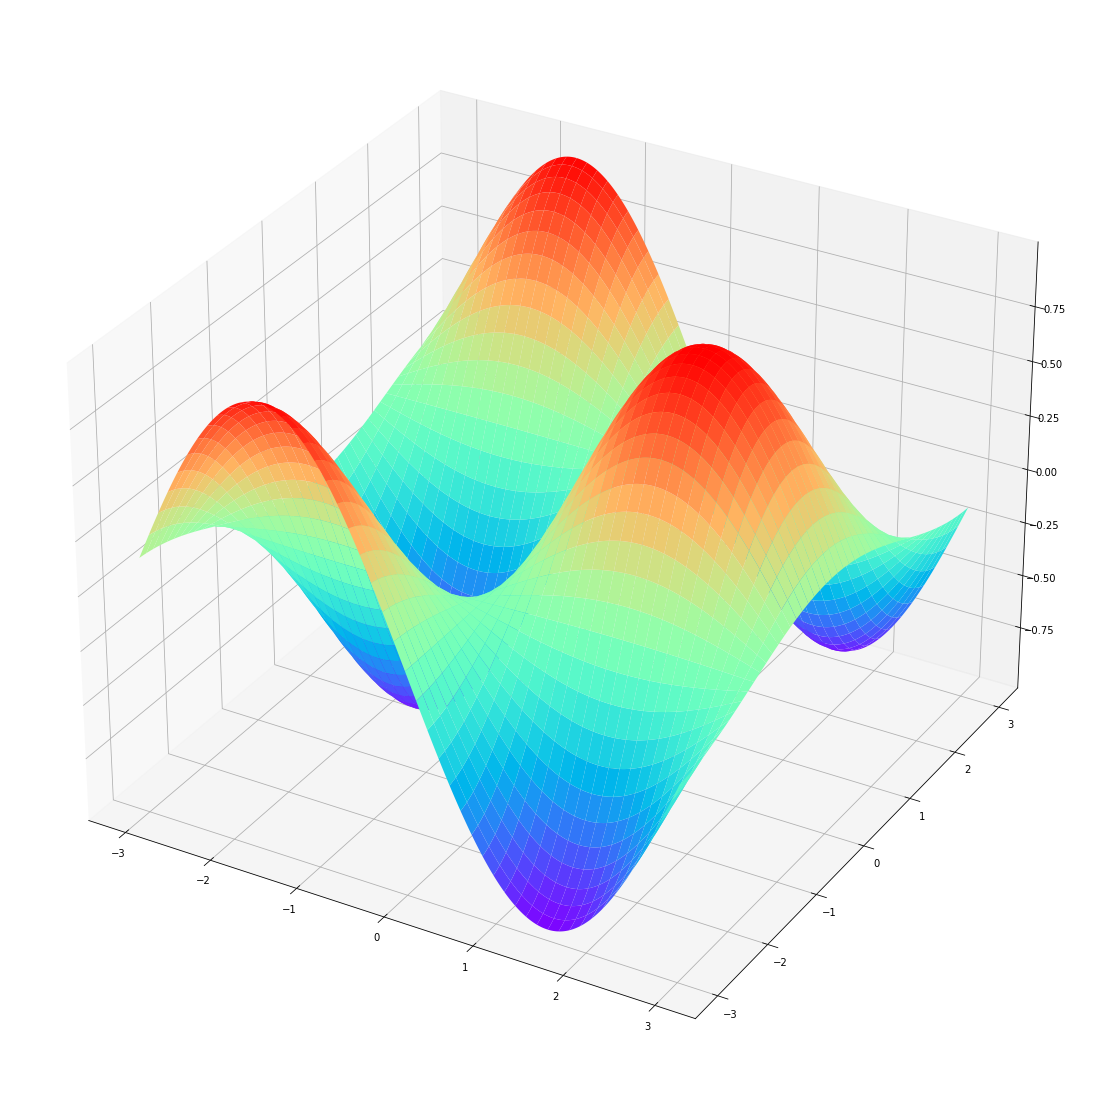

In [9]:
# 对函数进行拟合

# 拟合函数f(x1, x2) = sin(x1)cos(x2)
# x1范围[-3, 3]，总点数300
# x2范围[-3, 3]，总点数300

x1, x2 = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
show_y_list = np.sin(x1) * np.cos(x2)

fig = plt.figure(figsize=(15, 15))
axes3d = Axes3D(fig)
axes3d.plot_surface(x1, x2, show_y_list, cmap="rainbow")
plt.show()


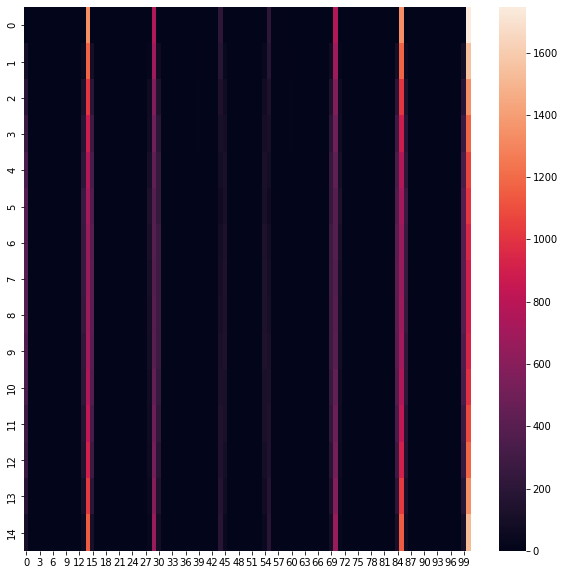

参数学习
[1/10]	 train loss:0.78708
[2/10]	 train loss:0.06619
[3/10]	 train loss:0.03601
[4/10]	 train loss:0.02800
[5/10]	 train loss:0.02467
[6/10]	 train loss:0.02293
[7/10]	 train loss:0.02189
[8/10]	 train loss:0.02122
[9/10]	 train loss:0.02076
[10/10]	 train loss:0.02044


In [118]:
x1, x2 = np.meshgrid(np.linspace(-3, 3, 80), np.linspace(-3, 3, 80))

train_x_list = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis=1)
train_y_list = np.sin(train_x_list[:, 0:1]) * np.cos(train_x_list[:, 1:])

# 输入维度
input_dim = 2
# 输入范围
input_range = [[-3, 3], [-3, 3]]
# 量化级
q_levle = [50, 50]
# 扩充地址空间维度
expend_dim = 15
# 散列质数
hash_number = 101
# 学习率
lr = 0.009
# 最大epoch
max_epoch = 10

# 定义模型
my_cmac = CMAC(input_dim=input_dim,
               input_range=input_range,
               q_level=q_levle,
               expend_dim=expend_dim,
               hash_number=hash_number,
               lr=lr)

# 探测碰撞
real_address_heatmap = np.zeros((expend_dim, hash_number))
for train_sample in train_x_list:
    pred_y = my_cmac.forward(train_sample)
    real_address_heatmap[range(0, my_cmac.expend_dim), my_cmac.real_vector.reshape(-1)-1] += 1

plt.figure(figsize=(10, 10))
sn.heatmap(real_address_heatmap)
plt.show()

# 参数优化
print("参数学习")
for epoch in range(max_epoch):

    train_loss = 0
    for step, train_sample in enumerate(train_x_list):
        pred_y = my_cmac.forward(train_sample)
        my_cmac.optim(train_y_list[step][0])
        
        train_loss += pow(pred_y - train_y_list[step][0], 2)
    
    print("[{}/{}]\t train loss:{:.5f}".format(epoch+1, max_epoch, train_loss/len(train_x_list)))

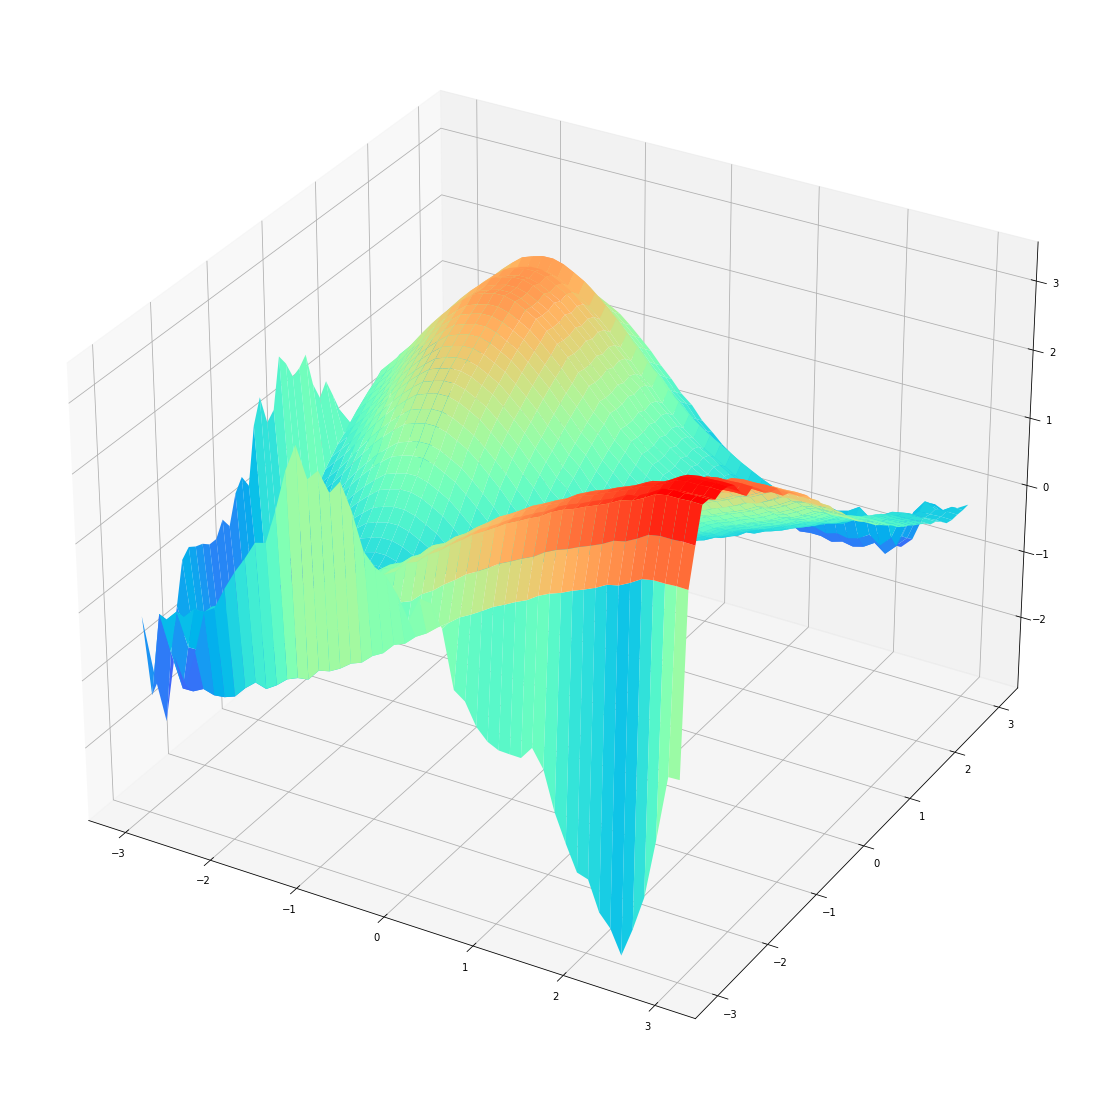

In [115]:
# 预测输出
x1, x2 = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
val_true_y = np.sin(x1) * np.cos(x2)

val_pred_y = np.zeros((50, 50))

for i in range(50):
    for j in range(50):
        val_pred_y[i][j] = my_cmac.forward([x1[i][j], x2[i][j]])

fig = plt.figure(figsize=(15, 15))
axes3d = Axes3D(fig)
axes3d.plot_surface(x1, x2, val_pred_y, cmap="rainbow")
# axes3d.plot_surface(x1, x2, val_true_y, cmap="gray", alpha=0.5)
plt.show()